“I have done this assignment completely on my own. I have not copied it, nor have I given my solution to anyone else. I understand that if I am involved in plagiarism or cheating, I will have to sign an official form that I have cheated and that this form will be stored in my official university record. I also understand that I will receive a grade of 0 for the involved assignment and my grade will be reduced by one level (e.g., from A to A- or from B+ to B) for my first offense, and that I will receive a grade of “F” for the course for any additional offense of any kind.”

Shreya Karunakar Shetty


## Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Data preprocessing
def preprocess_data(csv_folder):
    file_list = []
    
    # Loading all CSV files
    for f_name in os.listdir(csv_folder):
        if f_name.endswith('.csv'):
            f_path = os.path.join(csv_folder, f_name)
            data = pd.read_csv(f_path)
            file_list.append(data)

    # Merginginto a single df
    df = pd.concat(file_list, ignore_index=True)

    # Removing duplicates
    original_shape = df.shape
    df_cleaned = df.drop_duplicates()
    df_shape = df_cleaned.shape
    print(f'Original shape of the df - {original_shape}, Cleaned shape of the df - {df_shape}')
    
    return df_cleaned

# Loading and preprocessinf the data
csv_folder = r'C:\Users\shrey\Downloads\data_5drivers'  
df_cleaned = preprocess_data(csv_folder)


C:\Users\shrey\AppData\Local\Temp\ipykernel_18064\3766012231.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(file_list, ignore_index=True)


Original shape of the df - (4187013, 5), Cleaned shape of the df - (4169966, 5)


## Data Preprocessing

In [2]:
# Convertingh the feature time to datetime
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'])
df_cleaned['time_in_seconds'] = df_cleaned['time'].dt.hour * 3600 + df_cleaned['time'].dt.minute * 60 + df_cleaned['time'].dt.second

# Normalizeation
df_cleaned['longitude_norm'] = (df_cleaned['longitude'] - df_cleaned['longitude'].min()) / (df_cleaned['longitude'].max() - df_cleaned['longitude'].min())
df_cleaned['latitude_norm'] = (df_cleaned['latitude'] - df_cleaned['latitude'].min()) / (df_cleaned['latitude'].max() - df_cleaned['latitude'].min())

# Calculating speed
df_cleaned['speed'] = np.sqrt(np.diff(df_cleaned['latitude'], prepend=df_cleaned['latitude'].iloc[0])**2 + 
                                np.diff(df_cleaned['longitude'], prepend=df_cleaned['longitude'].iloc[0])**2)

# Sin & Cos transformation for time
df_cleaned['time_sin'] = np.sin(df_cleaned['time_in_seconds'] * (2 * np.pi / 86400))
df_cleaned['time_cos'] = np.cos(df_cleaned['time_in_seconds'] * (2 * np.pi / 86400))


In [3]:
d_seq = df_cleaned.groupby('plate', as_index=False).apply(lambda x: x.sort_values('time_in_seconds')).reset_index(drop=True)

# Generating features and labels
sequnce = []
labels = []
seq_length = 10

for plt, grp in d_seq.groupby('plate'):
    for i in range(len(grp) - seq_length):
        seq = grp.iloc[i:i + seq_length][['longitude_norm', 'latitude_norm', 'speed', 'time_sin', 'time_cos']].values
        label = plt
        sequnce.append(seq)
        labels.append(label)

# Converting to numpy arrays
X = np.array(sequnce)
y = np.array(labels)

# One-hot encoding
lb = LabelBinarizer()
y_categorical = lb.fit_transform(y)


In [20]:
# Calculating Min and Max Longitude and Latitude for testing the test data
min_long = df_cleaned['longitude'].min()
max_long = df_cleaned['longitude'].max()

min_lat = df_cleaned['latitude'].min()
max_lat = df_cleaned['latitude'].max()

print(f"Min Longitude: {min_long}, Max Longitude: {max_long}")
print(f"Min Latitude: {min_lat}, Max Latitude: {max_lat}")


Min Longitude: 100.267, Max Longitude: 767.0096599999999
Min Latitude: 16.0028, Max Latitude: 28028.0


In [4]:
# Spliting data
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


## Model Initiation

## Model 1

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

def fcn_model(input_shape, num_classes):
    model = Sequential()
    
    # Flattening the input
    model.add(Flatten(input_shape=input_shape))
    
    # Adding dense layers and droputs
    model.add(Dense(32, activation='relu'))  
    model.add(Dropout(0.5)) 
    
    model.add(Dense(16, activation='relu')) 
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

ip_shape = (X_train.shape[1], X_train.shape[2]) 
num_classes = y_train.shape[1] 

model = fcn_model(ip_shape, num_classes)

# Compiling the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


C:\Users\shrey\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,245 (8.77 KB)

 Trainable params: 2,245 (8.77 KB)

 Non-trainable params: 0 (0.00 B)

## Training Accuracy

In [22]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training  the model
hist = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20, 
                    batch_size=32, 
                    callbacks=[early_stopping])
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}")

Epoch 1/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 257s 2ms/step - accuracy: 0.2526 - loss: 1.6578 - val_accuracy: 0.2430 - val_loss: 1.5757
Epoch 2/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 249s 2ms/step - accuracy: 0.2461 - loss: 1.6041 - val_accuracy: 0.2458 - val_loss: 1.5867
Epoch 3/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 290s 3ms/step - accuracy: 0.2466 - loss: 1.5858 - val_accuracy: 0.2437 - val_loss: 1.5797
Epoch 4/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 285s 3ms/step - accuracy: 0.2473 - loss: 1.5834 - val_accuracy: 0.2430 - val_loss: 1.5564
Epoch 5/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 284s 3ms/step - accuracy: 0.2477 - loss: 1.5814 - val_accuracy: 0.2430 - val_loss: 1.5626
Epoch 6/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 278s 3ms/step - accuracy: 0.2477 - loss: 1.5792 - val_accuracy: 0.3067 - val_loss: 1.5578
Epoch 7/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 272s 3ms/step - accuracy: 0.2505 - loss: 1.5766 - val_accuracy: 0.2474 - val_loss: 1.5640
Epoch 8/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 28

## Visualization

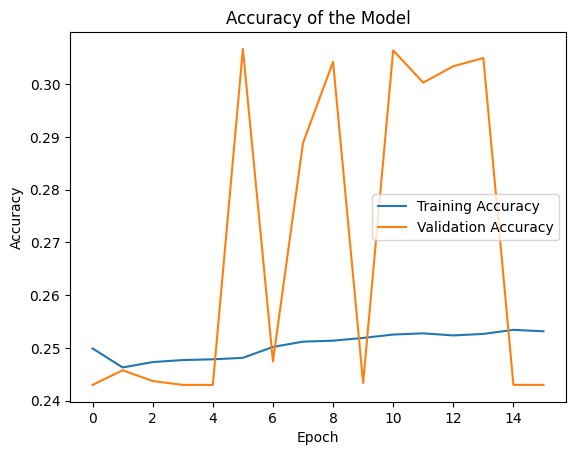

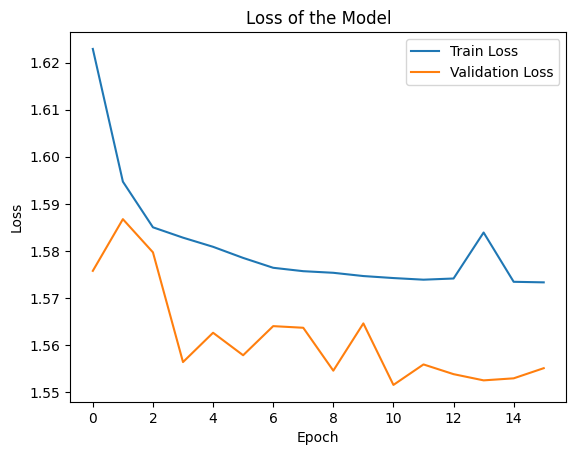

In [23]:
import matplotlib.pyplot as plt

# Visualization
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Loss of the Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Model 2

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Model definition
def lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))  
    model.add(Dropout(0.2)) 
    model.add(LSTM(32)) 
    model.add(Dropout(0.2))  
    model.add(Dense(num_classes, activation='softmax'))
    return model

ip_shape = (X_train.shape[1], X_train.shape[2]) 
num_classes = y_train.shape[1] 
model = lstm_model(ip_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,501 (119.14 KB)

 Trainable params: 30,501 (119.14 KB)

 Non-trainable params: 0 (0.00 B)

## Training Accuracy

In [17]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training  the model
hist = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20, 
                    batch_size=32, 
                    callbacks=[early_stopping])
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}")



Epoch 1/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 1292s 12ms/step - accuracy: 0.4583 - loss: 1.2765 - val_accuracy: 0.4803 - val_loss: 1.2312
Epoch 2/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 1415s 14ms/step - accuracy: 0.4754 - loss: 1.2464 - val_accuracy: 0.4890 - val_loss: 1.2164
Epoch 3/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 1469s 14ms/step - accuracy: 0.4822 - loss: 1.2325 - val_accuracy: 0.4906 - val_loss: 1.2121
Epoch 4/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 1541s 14ms/step - accuracy: 0.4873 - loss: 1.2232 - val_accuracy: 0.4969 - val_loss: 1.2003
Epoch 5/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 1508s 14ms/step - accuracy: 0.4909 - loss: 1.2161 - val_accuracy: 0.4990 - val_loss: 1.1967
Epoch 6/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 1529s 15ms/step - accuracy: 0.4934 - loss: 1.2119 - val_accuracy: 0.5020 - val_loss: 1.1906
Epoch 7/20
104248/104248 ━━━━━━━━━━━━━━━━━━━━ 1552s 15ms/step - accuracy: 0.4961 - loss: 1.2069 - val_accuracy: 0.5034 - val_loss: 1.1863
Epoch 8/20
104248/104248 ━━━━━━━━━

## Saving the model

In [18]:
model.save('taxi_driver_model.h5') 

## Visualization

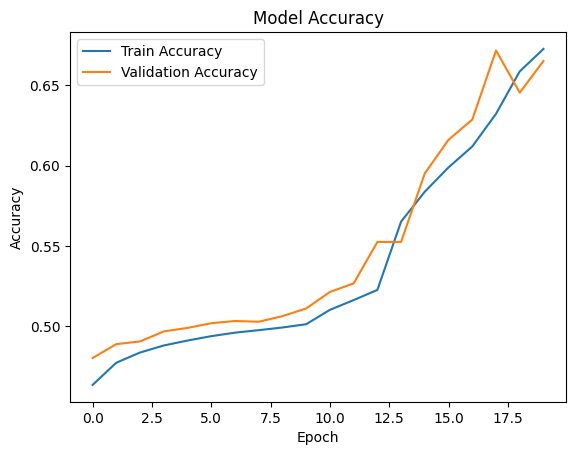

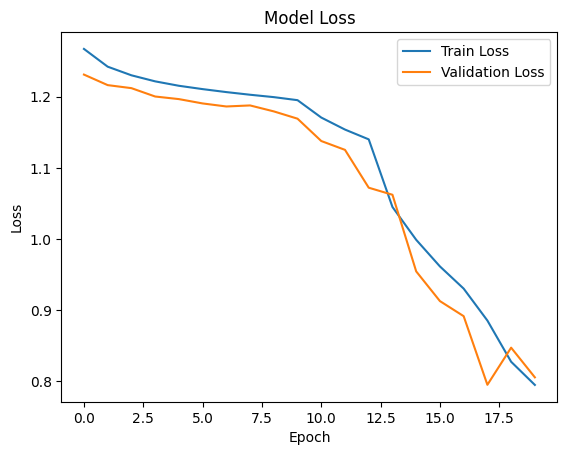

In [19]:
import matplotlib.pyplot as plt

# Visualize training history
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
